# Try iRF on the enhancer data

This notebook runs iRF on enhancer data. It also tries to analyze the result using debiased feature importance.

In [1]:
import rpy2.robjects as robjects
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
#from sklearn.ensemble import RandomForestClassifier
from irf import irf_utils, irf_jupyter_utils
from irf.irf_utils import run_iRF
from irf.ensemble import RandomForestClassifier
from treeinterpreter.feature_importance import feature_importance
#from rfms.storytellers import test_feature_importance
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## read the data

In [2]:
tmp = robjects.r['load']('../iRF_analyses/data/enhancer.Rdata')
print(tmp)
X = robjects.r["X"]
XX = np.asarray(X)
print(XX)
assert(len(XX[0]) == X.ncol) #same number of cols
assert(len(XX) == X.nrow)
X = XX
Y = robjects.r["Y"]
Y = np.asarray(Y)
assert(len(Y) == len(X))
test = np.asarray(robjects.r["test.id"])
train = np.asarray(robjects.r["train.id"])
varnames = np.asarray(robjects.r["varnames.all"])

[1] "X"            "Y"            "test.id"      "train.id"     "varnames.all"

[[ 6.      10.      10.      ...  0.       0.       0.     ]
 [ 6.       7.       6.      ...  0.       0.       0.     ]
 [14.       9.      14.      ...  0.       0.       1.2013 ]
 ...
 [ 9.      12.      16.      ...  2.13176  2.22051  1.20134]
 [17.      18.      14.      ...  1.49709  1.39971  1.26398]
 [13.      15.      18.      ...  2.03769  2.03994  0.     ]]


## train test split

In [3]:
X_train = X[train-1,:]
X_test = X[test-1,:]
y_train = Y[train - 1]
y_test = Y[test - 1]

### store in the data folder

In [4]:
pd.DataFrame(X_train).to_csv('../data/01_X_train.csv')
pd.DataFrame(X_test).to_csv('../data/02_X_test.csv')
pd.DataFrame(y_train).to_csv('../data/03_y_train.csv')
pd.DataFrame(y_test).to_csv('../data/04_y_test.csv')

## train iRF

In [4]:
rf = RandomForestClassifier(n_estimators=50, max_depth=5)
all_rf_weights, \
all_K_iter_rf_data, \
all_rf_bootstrap_output, \
all_rit_bootstrap_output, \
stability_score = run_iRF(X_train, X_test, y_train, y_test, rf, 
        K = 4,
        B = 100)

### evaluate the final prediction accuracy

In [5]:
# get the final predictor
rf.fit(X_train, y_train, feature_weight=all_rf_weights['rf_weight4'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [6]:
print(' IRF\'s mean accuracy on training is %.4f'%(accuracy_score(y_train, rf.predict(X_train))))
print(' IRF\'s mean accuracy on test is %.4f'%(accuracy_score(y_test, rf.predict(X_test))))
print(' IRF\'s MSE is %.4f'%(mean_squared_error(y_test, rf.predict_proba(X_test)[:,1])))

 IRF's mean accuracy on training is 0.9450
 IRF's mean accuracy on test is 0.9266
 IRF's MSE is 0.0589


In [7]:
irf_right_cases = y_test == rf.predict(X_test)

### Save the model 

In [31]:
import pickle as pk
with open('../results/01_irf_model.pickle', 'wb') as f:
    pk.dump(rf, f)

# Examine the stability scores

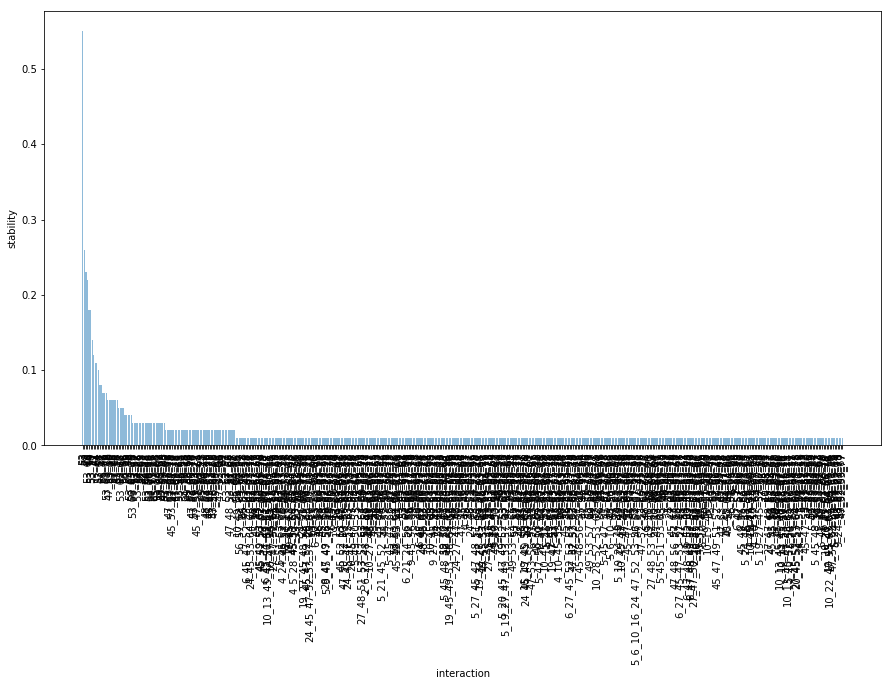

In [7]:
irf_jupyter_utils._get_histogram(stability_score, sort = True)

That's interesting - feature 22, 27, 20, 23 keep popping up!

We should probably look at the feature importances to understand if there is a useful correlation

# Examine feature importances
In particular, let us see how they change over the K iterations of random forest

['gt2' 'kr' 'med2' 'tll' 'twi' 'kr' 'cad1' 'D1' 'twi' 'hb' 'wt_ZLD' 'hb'
 'bcd' 'prdBQ' 'kni' 'ftz3' 'da2' 'run' 'dl3' 'hkb' 'H3K4me1' 'kni'
 'H3K4me1' 'prdFQ' 'sna' 'H3K18ac' 'H3K18ac' 'hkb' 'H3K27ac' 'sna'
 'H3K27ac' 'wt_H3K18ac' 'H3K9ac' 'H3' 'H3K18ac' 'wt_H3' 'H3K36me3' 'bcd'
 'H3K36me3' 'H3K4me3' 'H3' 'H3K18ac' 'H3K27me3' 'mad2' 'run' 'H3K4me3'
 'H4K5ac' 'wt_H3K4me1' 'h' 'H4K8ac' 'H3K9ac' 'H3K9ac' 'input3' 'input2'
 'hkb' 'input1' 'z2' 'H4K5ac' 'H4K8ac' 'input4' 'H4K8ac' 'H3K4me1'
 'H3K27ac' 'slp' 'H4K5ac' 'H3' 'H3' 'h' 'H4K8ac' 'H3K36me3' 'H3K27me3'
 'H3K27me3' 'H4K5ac' 'H3K4me1' 'shn' 'H3K4me3' 'H3K9ac' 'H3K27ac' 'shn'
 'H3K4me3']


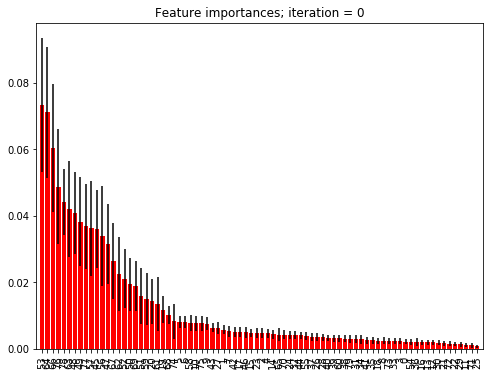

['gt2' 'kr' 'med2' 'twi' 'kr' 'twi' 'bcd' 'hb' 'hb' 'D1' 'wt_ZLD' 'cad1'
 'prdBQ' 'ftz3' 'kni' 'da2' 'tll' 'dl3' 'run' 'hkb' 'H3K4me1' 'prdFQ'
 'sna' 'H3K18ac' 'H3K18ac' 'z2' 'wt_H3K18ac' 'H3K27ac' 'H3K9ac' 'H3K4me1'
 'H3K27ac' 'H3K4me3' 'H3' 'hkb' 'H3K4me3' 'H3K9ac' 'H3' 'H3K36me3' 'wt_H3'
 'H3K18ac' 'sna' 'H3K18ac' 'input3' 'H4K8ac' 'h' 'bcd' 'H3K9ac' 'H4K5ac'
 'H3K36me3' 'H4K5ac' 'H4K5ac' 'H3K27me3' 'h' 'input1' 'H3K4me1' 'H4K5ac'
 'H3K27ac' 'H3K27me3' 'slp' 'H3K4me1' 'H3K27me3' 'H4K8ac' 'H3K36me3'
 'mad2' 'hkb' 'wt_H3K4me1' 'H4K8ac' 'run' 'H3K4me3' 'H4K8ac' 'H3K9ac'
 'kni' 'input4' 'H3' 'input2' 'H3K27ac' 'H3K4me3' 'shn' 'shn' 'H3']


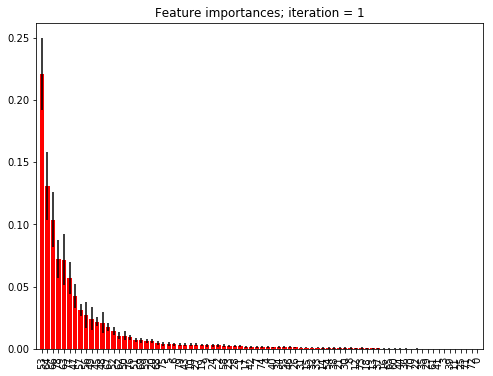

['gt2' 'kr' 'twi' 'med2' 'kr' 'twi' 'bcd' 'hb' 'hb' 'cad1' 'wt_ZLD' 'ftz3'
 'prdBQ' 'kni' 'D1' 'da2' 'H3K18ac' 'H3K18ac' 'H3K4me3' 'dl3' 'prdFQ'
 'H3K27ac' 'H3K4me1' 'sna' 'H3K9ac' 'tll' 'run' 'H3K4me1' 'H3K4me3' 'hkb'
 'z2' 'H3' 'H3K27ac' 'H3' 'wt_H3' 'H3K9ac' 'H3K27me3' 'input3' 'H3K36me3'
 'hkb' 'wt_H3K18ac' 'H3K27me3' 'H3K4me1' 'H3K18ac' 'H3K36me3' 'h' 'H3K9ac'
 'H3K4me3' 'input1' 'H3K18ac' 'H4K5ac' 'H3K27ac' 'H3K4me1' 'H4K8ac'
 'H3K36me3' 'H3' 'H3K27me3' 'H3K27ac' 'input2' 'H3K4me3' 'h' 'sna' 'slp'
 'shn' 'shn' 'run' 'mad2' 'kni' 'hkb' 'bcd' 'H3K9ac' 'wt_H3K4me1' 'input4'
 'H4K8ac' 'H4K8ac' 'H4K8ac' 'H4K5ac' 'H4K5ac' 'H4K5ac' 'H3']


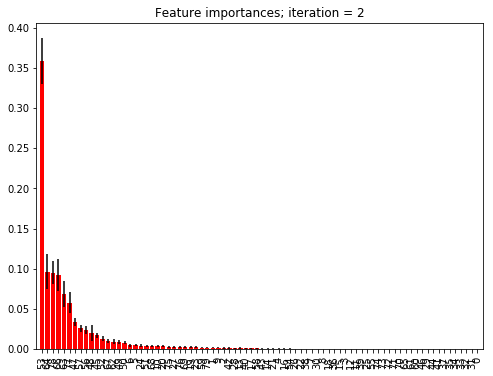

['gt2' 'twi' 'kr' 'bcd' 'med2' 'kr' 'twi' 'hb' 'hb' 'wt_ZLD' 'prdBQ'
 'ftz3' 'cad1' 'H3K18ac' 'D1' 'H3K27ac' 'kni' 'H3K9ac' 'da2' 'H3K4me3'
 'dl3' 'H3K4me1' 'H3K18ac' 'run' 'tll' 'prdFQ' 'H3K27ac' 'H3' 'H3K4me1'
 'H3K18ac' 'H3K27me3' 'hkb' 'H3K4me1' 'H3K9ac' 'h' 'H3K27me3' 'H3K36me3'
 'H3K4me3' 'H3K18ac' 'H4K8ac' 'z2' 'sna' 'H3K36me3' 'H3K4me1' 'H3K36me3'
 'H3K27ac' 'H3K27ac' 'H3' 'H3K4me3' 'H3' 'H3K4me3' 'H3K9ac' 'H3K27me3'
 'input2' 'H3K9ac' 'H4K5ac' 'sna' 'slp' 'shn' 'shn' 'run' 'mad2' 'kni'
 'hkb' 'hkb' 'h' 'bcd' 'wt_H3K4me1' 'wt_H3K18ac' 'wt_H3' 'input4' 'input3'
 'input1' 'H4K8ac' 'H4K8ac' 'H4K8ac' 'H4K5ac' 'H4K5ac' 'H4K5ac' 'H3']


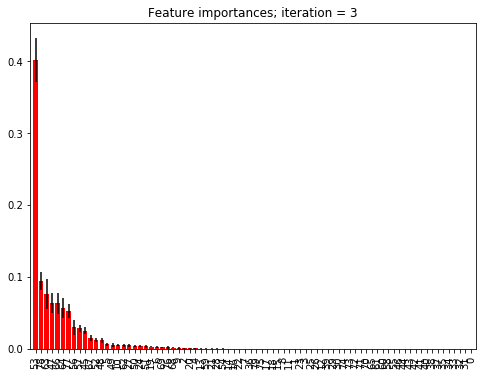

In [8]:
top = 20
for k in range(4): 
    
    iteration = "rf_iter{}".format(k)
    
    feature_importances_std = all_K_iter_rf_data[iteration]['feature_importances_std'] / rf.n_estimators ** .5
    feature_importances_rank_idx = all_K_iter_rf_data[iteration]['feature_importances_rank_idx']
    print(varnames[1,feature_importances_rank_idx])
    feature_importances = all_K_iter_rf_data[iteration]['feature_importances']

    plt.figure(figsize=(8, 6))
    title = "Feature importances; iteration = {}".format(k)
    plt.title(title)
    plt.bar(range(X_train.shape[1])
            , feature_importances[feature_importances_rank_idx]
            , color="r"
            , yerr = feature_importances_std[feature_importances_rank_idx], align="center")
    plt.xticks(range(X_train.shape[1]), feature_importances_rank_idx, rotation='vertical')
    plt.xlim([-1, X_train.shape[1]])
    plt.show()   

## calculate the OOB debiased feature importance

### fit the weighted RF first

In [42]:
rf = RandomForestClassifier(n_estimators=50, max_depth=5)
rf.fit(X_train, y_train, feature_weight=all_K_iter_rf_data["rf_iter{}".format(0)]['feature_importances'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [43]:
print(' IRF\'s mean accuracy on training is %.4f'%(accuracy_score(y_train, rf.predict(X_train))))
print(' IRF\'s mean accuracy on test is %.4f'%(accuracy_score(y_test, rf.predict(X_test))))
print(' IRF\'s MSE is %.4f'%(mean_squared_error(y_test, rf.predict_proba(X_test)[:,1])))

 IRF's mean accuracy on training is 0.9445
 IRF's mean accuracy on test is 0.9266
 IRF's MSE is 0.0589


In [44]:
from sklearn.preprocessing import OneHotEncoder
y_train_one_hot = OneHotEncoder().fit(y_train[:,np.newaxis]).transform(y_train[:,np.newaxis]).todense()
y_test_one_hot = OneHotEncoder().fit(y_train[:,np.newaxis]).transform(y_test[:,np.newaxis]).todense()
#test_importance, test_SE = feature_importance(rf, X_test, y_test_one_hot, type = 'test')
oob_importance, oob_SE = feature_importance(rf, X_train, y_train_one_hot, type = 'oob')
test_importance, test_SE = feature_importance(rf, X_test, y_test_one_hot, type = 'test')

## plot debiased feature importance

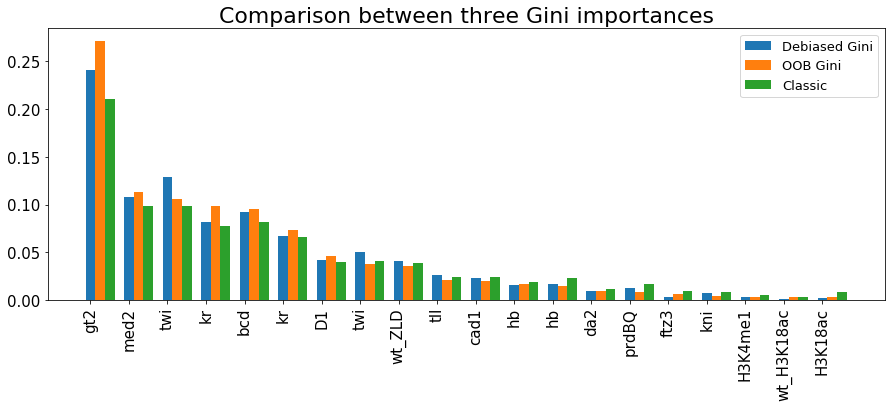

In [45]:
p = X_train.shape[1]
ix = np.argsort(oob_importance)
plt.figure(figsize = (15, 5))
plt.bar(x = list(reversed(range(p)))[60:], height = test_importance[ix][60:], width = .25)
plt.bar(x = np.array(list(reversed(range(p))))[60:]+.25, height = oob_importance[ix][60:], width = .25)
plt.bar(x = np.array(list(reversed(range(p))))[60:]+.5, height = rf.feature_importances_[ix][60:], width = .25)
plt.legend(['Debiased Gini', 'OOB Gini', 'Classic'], fontsize = 13)
plt.title('Comparison between three Gini importances', fontsize = 22)
plt.xticks(19 - np.arange(20), varnames[1,ix][60:], rotation = 90)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

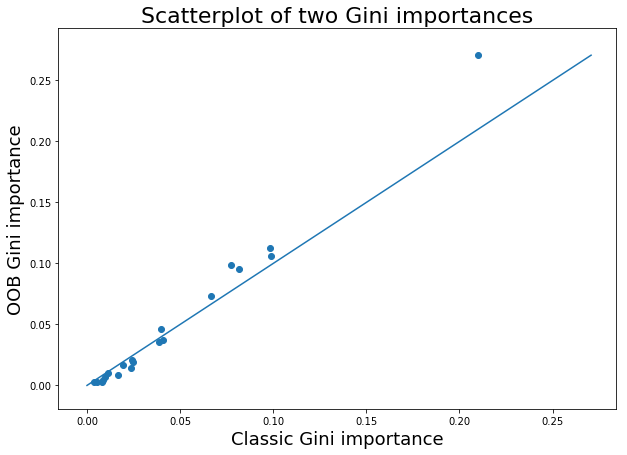

In [55]:
ix = np.argsort(oob_importance)
plt.figure(figsize = (10, 7))
plt.scatter(x = rf.feature_importances_[ix][60:], y = oob_importance[ix][60:])
plt.title('Scatterplot of two Gini importances', fontsize = 22)
plt.xlabel('Classic Gini importance', fontsize = 18)
plt.ylabel('OOB Gini importance', fontsize = 18)
plt.plot([0, max(oob_importance)], [0, max(oob_importance)])
plt.show()

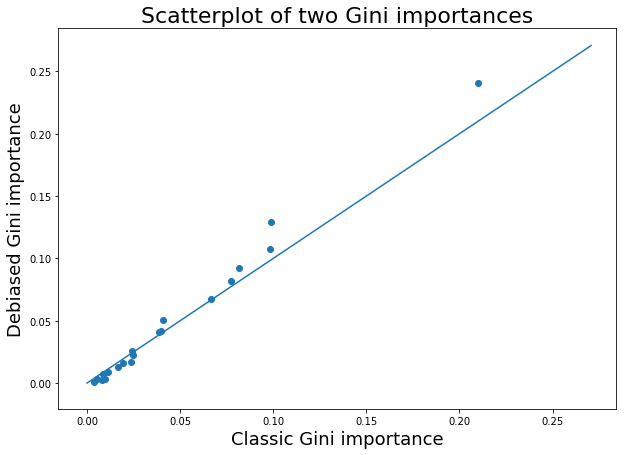

In [56]:
ix = np.argsort(oob_importance)
plt.figure(figsize = (10, 7))
plt.scatter(x = rf.feature_importances_[ix][60:], y = test_importance[ix][60:])
plt.title('Scatterplot of two Gini importances', fontsize = 22)
plt.xlabel('Classic Gini importance', fontsize = 18)
plt.ylabel('Debiased Gini importance', fontsize = 18)
plt.plot([0, max(oob_importance)], [0, max(oob_importance)])
plt.show()

## give the set of features that is above the threshold

In [128]:
varnames[1,:]

array(['H3', 'H3', 'H3', 'H3', 'H3K18ac', 'H3K18ac', 'H3K18ac', 'H3K18ac',
       'H3K27ac', 'H3K27ac', 'H3K27ac', 'H3K27ac', 'H3K27me3', 'H3K27me3',
       'H3K27me3', 'H3K36me3', 'H3K36me3', 'H3K36me3', 'H3K4me1',
       'H3K4me1', 'H3K4me1', 'H3K4me1', 'H3K4me3', 'H3K4me3', 'H3K4me3',
       'H3K4me3', 'H3K9ac', 'H3K9ac', 'H3K9ac', 'H3K9ac', 'H4K5ac',
       'H4K5ac', 'H4K5ac', 'H4K5ac', 'H4K8ac', 'H4K8ac', 'H4K8ac',
       'H4K8ac', 'input1', 'input2', 'input3', 'input4', 'wt_H3',
       'wt_H3K18ac', 'wt_H3K4me1', 'wt_ZLD', 'bcd', 'bcd', 'cad1', 'D1',
       'da2', 'dl3', 'ftz3', 'gt2', 'h', 'h', 'hb', 'hb', 'hkb', 'hkb',
       'hkb', 'kni', 'kni', 'kr', 'kr', 'mad2', 'med2', 'prdBQ', 'prdFQ',
       'run', 'run', 'shn', 'shn', 'slp', 'sna', 'sna', 'tll', 'twi',
       'twi', 'z2'], dtype='<U13')

In [129]:
selected_features = rf.feature_importances_ > 0.0
varnames[1,selected_features]

array(['H3', 'H3K18ac', 'H3K18ac', 'H3K18ac', 'H3K27ac', 'H3K27ac',
       'H3K27me3', 'H3K4me1', 'H3K4me1', 'H3K4me1', 'H3K4me3', 'H3K4me3',
       'H3K9ac', 'wt_ZLD', 'bcd', 'cad1', 'D1', 'da2', 'dl3', 'ftz3',
       'gt2', 'h', 'hb', 'hb', 'kni', 'kr', 'kr', 'med2', 'prdBQ',
       'prdFQ', 'run', 'sna', 'tll', 'twi', 'twi', 'z2'], dtype='<U13')

In [130]:
selected_features = oob_importance > oob_SE * 2
varnames[1,selected_features]

array(['wt_ZLD', 'bcd', 'ftz3', 'gt2', 'hb', 'hb', 'kni', 'kr', 'kr',
       'med2', 'prdBQ', 'twi', 'twi'], dtype='<U13')

### oob_importance brings the number of useful features down from 32 to 22.

### refit the random forest

In [161]:
rf = RandomForestClassifier(n_estimators=50, max_depth=5)
rf.fit(X_train, y_train, feature_weight=np.maximum(oob_importance - oob_SE * 2, 0))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [162]:
print(' IRF\'s mean accuracy on training is %.4f'%(accuracy_score(y_train, rf.predict(X_train))))
print(' IRF\'s mean accuracy on test is %.4f'%(accuracy_score(y_test, rf.predict(X_test))))
print(' IRF\'s MSE is %.4f'%(mean_squared_error(y_test, rf.predict_proba(X_test)[:,1])))

 IRF's mean accuracy on training is 0.9450
 IRF's mean accuracy on test is 0.9253
 IRF's MSE is 0.0599


### The result shows that using the top features selected via debiased feature importance gives similar test performance.

In [163]:
oob_refitted_right_cases = y_test == rf.predict(X_test)

In [164]:
np.unique([str((x, y)) for x, y in zip(oob_refitted_right_cases, irf_right_cases)], return_counts=True)

(array(['(False, False)', '(False, True)', '(True, False)', '(True, True)'],
       dtype='<U14'), array([ 273,   18,   13, 3593]))

In [166]:
from statsmodels.stats.contingency_tables import mcnemar
result = mcnemar([ [273,   18],   [13, 3593]])
result.pvalue

0.4731296598911284

### Using Fisher's exact test, there is no difference between the two predictions

<hr />

This section compares the rank of features using the original feature importance and the debiased version.

In [189]:
from scipy.stats import rankdata
rf = RandomForestClassifier(n_estimators=50, max_depth=5)
rf.fit(X_train, y_train, feature_weight=all_K_iter_rf_data["rf_iter{}".format(3)]['feature_importances'])
oob_importance, oob_SE = feature_importance(rf, X_train, y_train_one_hot, type = 'oob')
a1 = rankdata(rf.feature_importances_)
a2 = rankdata(oob_importance)

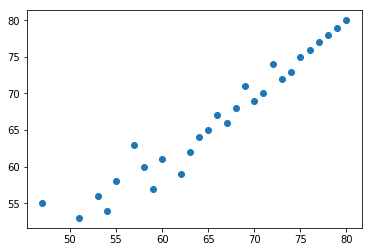

In [190]:
plt.scatter(a1[a2 > 50], a2[a2 > 50])

### The ranks are similar but not always the same

In [191]:
threshold = 60
ix1 = np.argsort(-rf.feature_importances_)
ix2 = np.argsort(-oob_importance)

np.array([(x, y) for x, y in zip(varnames[1, ix1], varnames[1, ix2])])

array([['gt2', 'gt2'],
       ['twi', 'twi'],
       ['kr', 'kr'],
       ['med2', 'med2'],
       ['bcd', 'bcd'],
       ['twi', 'twi'],
       ['kr', 'hb'],
       ['wt_ZLD', 'kr'],
       ['hb', 'wt_ZLD'],
       ['hb', 'cad1'],
       ['prdBQ', 'hb'],
       ['cad1', 'prdBQ'],
       ['ftz3', 'ftz3'],
       ['H3K18ac', 'H3K9ac'],
       ['H3K9ac', 'H3K18ac'],
       ['H3K4me3', 'H3K4me3'],
       ['da2', 'da2'],
       ['H3K27ac', 'H3K18ac'],
       ['H3K27ac', 'H3K27ac'],
       ['D1', 'kni'],
       ['kni', 'H3K4me1'],
       ['H3K18ac', 'H3K27ac'],
       ['H3K4me1', 'H3K9ac'],
       ['H3K18ac', 'H3K18ac'],
       ['run', 'H3'],
       ['H3K9ac', 'H3K36me3'],
       ['tll', 'tll'],
       ['H3', 'H3K4me1'],
       ['H3K27me3', 'h'],
       ['H3K4me1', 'bcd'],
       ['h', 'H3'],
       ['dl3', 'hkb'],
       ['prdFQ', 'hkb'],
       ['H3K36me3', 'kni'],
       ['H3K4me3', 'mad2'],
       ['sna', 'run'],
       ['sna', 'shn'],
       ['shn', 'shn'],
       ['hkb', 'slp'],
     

### The order of the feature importances remains the same for debiased and original gini importance.

<hr />

In [213]:
from scipy.stats import rankdata
rf = RandomForestClassifier(n_estimators=50, max_depth=5)
rf.fit(X_train, y_train, feature_weight=all_K_iter_rf_data["rf_iter{}".format(0)]['feature_importances'])
y_train_one_hot = OneHotEncoder().fit(y_train[:,np.newaxis]).transform(y_train[:,np.newaxis]).todense()
oob_importance, oob_SE = feature_importance(rf, X_train, y_train_one_hot, type = 'oob')
ix1 = np.argsort(-rf.feature_importances_)
ix2 = np.argsort(-oob_importance)
selected = oob_importance > oob_SE * 1
np.array([(x, y) for x, y in zip(varnames[1, ix1[selected]], varnames[1, ix2[selected]])])

array([['kr', 'kr'],
       ['hb', 'bcd'],
       ['twi', 'twi'],
       ['D1', 'kni'],
       ['ftz3', 'prdFQ'],
       ['tll', 'hkb'],
       ['hkb', 'ftz3'],
       ['prdFQ', 'H3K9ac'],
       ['H3K4me1', 'da2'],
       ['run', 'H3K4me1'],
       ['H3K27ac', 'H3K9ac'],
       ['H3', 'wt_H3'],
       ['H3K4me1', 'H3K4me3'],
       ['h', 'H3K27ac'],
       ['H3K9ac', 'H3K27me3'],
       ['H3K36me3', 'slp'],
       ['kni', 'mad2'],
       ['H3K36me3', 'H4K8ac'],
       ['H3K4me3', 'shn'],
       ['H4K8ac', 'H3'],
       ['H4K8ac', 'input1'],
       ['input3', 'shn'],
       ['H3K4me1', 'H4K5ac'],
       ['H4K8ac', 'H3K9ac'],
       ['H4K5ac', 'H3K27me3'],
       ['H3K27me3', 'input4'],
       ['mad2', 'input3'],
       ['H3', 'bcd'],
       ['H4K8ac', 'H3K27me3'],
       ['H3K27ac', 'H3K27ac'],
       ['hkb', 'H4K5ac'],
       ['run', 'hkb'],
       ['slp', 'z2'],
       ['input2', 'H4K8ac'],
       ['H3K27me3', 'H3K4me1'],
       ['input4', 'H3K4me1'],
       ['bcd', 'wt_H3K4me1'],
  

### For the first interation, the order is also similar but less stable compared to the last iteration. This could suggest that the order from the original RF is less useful.

<hr />

In [217]:
for i in range(4):
    rf = RandomForestClassifier(n_estimators=50, max_depth=5)
    rf.fit(X_train, y_train, feature_weight=all_K_iter_rf_data["rf_iter{}".format(0)]['feature_importances'])
    y_train_one_hot = OneHotEncoder().fit(y_train[:,np.newaxis]).transform(y_train[:,np.newaxis]).todense()
    oob_importance, oob_SE = feature_importance(rf, X_train, y_train_one_hot, type = 'oob')
    ix2 = np.argsort(-oob_importance)
    selected = oob_importance > oob_SE * 0
    print(varnames[1, ix2[selected]])

['med2' 'twi' 'kr' 'bcd' 'hb' 'D1' 'hb' 'tll' 'cad1' 'prdBQ' 'da2' 'kni'
 'H3K18ac' 'H3K4me3' 'H3K27ac' 'H3K9ac' 'prdFQ' 'sna' 'H3K4me1' 'H3K18ac'
 'run' 'H4K5ac' 'wt_H3K18ac' 'H3K18ac' 'H3K36me3' 'slp' 'hkb' 'H3'
 'H4K8ac' 'H4K8ac' 'input4' 'H3K18ac' 'H3K27me3' 'H4K5ac' 'H4K5ac'
 'H3K4me1' 'H4K5ac' 'wt_H3K4me1' 'H3K4me1' 'H3K27ac' 'input2' 'H4K8ac'
 'shn' 'H3K4me3' 'H3K4me3' 'h' 'input3' 'H3K36me3' 'H3K9ac' 'H3' 'H3K4me1'
 'run' 'z2' 'wt_H3' 'input1' 'H3K27me3' 'H3K27ac']
['med2' 'kr' 'bcd' 'tll' 'twi' 'hb' 'D1' 'prdBQ' 'H3K9ac' 'hkb' 'H3K18ac'
 'H3K4me3' 'H3K27ac' 'run' 'H3' 'mad2' 'input1' 'H3K27me3' 'H4K5ac'
 'H3K18ac' 'bcd' 'h' 'input2' 'H3K4me1' 'H3K4me3' 'H4K5ac' 'H3K9ac'
 'wt_H3' 'z2' 'H4K8ac' 'H4K8ac' 'H3K4me3' 'sna' 'H4K8ac' 'shn' 'shn'
 'H3K27ac' 'kni' 'run' 'H3K27ac' 'slp' 'H3K27ac' 'input4' 'hkb' 'H3K4me1'
 'H3K36me3' 'input3' 'H3K9ac' 'H4K8ac' 'H3K36me3' 'H3' 'H3K18ac']
['med2' 'twi' 'kr' 'wt_ZLD' 'twi' 'bcd' 'da2' 'hkb' 'cad1' 'run' 'H3K18ac'
 'bcd' 'H3K4me1' 'H3K27me3' 

### Note that the set is quite different when I run this multiple times. So it might not mean too much.